1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)
2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )
3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)
4. Build Popularity Recommender model.
5. Build Collaborative Filtering model.
6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)
7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.
8. Summarise your insights.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns
from surprise import SVD

In [2]:
df = pd.read_csv('ratings_Electronics.csv', header=None, names = ['user','product', 'rating'], usecols = [0,1,2])

In [3]:
df.head()

,user,product,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [4]:
df.shape

(7824482, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
user       object
product    object
rating     float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [6]:
df.describe()

,rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024C8E4AC7B8>]],
      dtype=object)

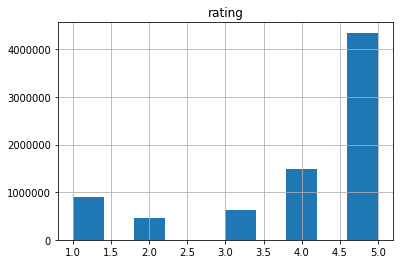

In [7]:
df.hist()

In [8]:
df.isnull().sum()

user       0
product    0
rating     0
dtype: int64

There are no null values in the dataset for any dataset. 

Rating feature is unbalanced. 

2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [9]:
df_cnt = df["user"].value_counts()

In [10]:
df1 = df[df["user"].isin(df_cnt[df_cnt >=50].index)]

In [11]:
df1.shape

(125871, 3)

3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_data, test_data = train_test_split(df1, test_size = 0.30, random_state=0)

In [14]:
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (88109, 3)
Test Data Shape:  (37762, 3)


4. Build Popularity Recommender model.

In [15]:
#finding products with high number of ratings: 
#Taking the entire Dataset for this model as train data doesnt makes sense. 
df1.groupby('product')['rating'].count().sort_values(ascending=False).head()

product
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: rating, dtype: int64

In [16]:
#finding products with high Average rating
df1.groupby('product')['rating'].mean().sort_values(ascending=False).head()

product
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: rating, dtype: float64

#### Building a popularity based recommender to recommend the top products with high mean ratings and rating count

In [17]:
# creating a dataframe with the list of products and the corresponding mean rating
ratings_mean_count = pd.DataFrame(df1.groupby('product')['rating'].mean())
ratings_mean_count.shape

(48190, 1)

In [18]:
# updating the number of ratings the product has received to a seperate column
ratings_mean_count['rating_counts'] = pd.DataFrame(df1.groupby('product')['rating'].count())

In [19]:
# a Dataframe with products, its mean data and number of Rating counts it has received is created. 
# This dataframe can subseqently used to give multiple recommendations
ratings_mean_count.head()

,rating,rating_counts
product,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


In [20]:
# displaying most popular products which has been rated by atleast 10 users
ratings_mean_count.sort_values(by = 'rating', axis = 0, ascending = False, inplace = True)
ratings_mean_count.head()

,rating,rating_counts
product,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


As we see multiple products which as 5 as mean rating has only one user rating. 

In [21]:
# Displaying list of products which has 5 rating and has been rated atleast by 15 users 
popular = ratings_mean_count.loc[(ratings_mean_count['rating'] == 5) & (ratings_mean_count['rating_counts'] > 15)] 

In [22]:
popular
# the same logic can be tweeked to throw multiple recommendations

,rating,rating_counts
product,,
B001TH7GUA,5.0,17
B00HG1L334,5.0,16
B00HZWJGS8,5.0,17
B00ISFNSBW,5.0,18
B005LDLP8W,5.0,16
B000IJY8DS,5.0,17
B000FQ2JLW,5.0,19


5. Build Collaborative Filtering model.

ratings_matrix1 = train_data.pivot(index='product', columns='user', values='rating').fillna(0)
user = ratings_matrix.columns
product = ratings_matrix.index
print(ratings_matrix1.shape)
ratings_matrix1.head()

In [24]:
df1.head()

,user,product,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [23]:
# Transforming data to surprise format
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))

In [25]:
# taking the entire dataset instead of the split train set. Will split it into train test set after converting to surprise format
data = Dataset.load_from_df(df1, reader)

In [26]:
data

In [27]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=123)

In [28]:
type(trainset)

surprise.trainset.Trainset

In [29]:
from surprise import KNNWithMeans
from surprise import accuracy

In [30]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


Model is built now with K value as 50. We are building a user - user colloborative model. 

6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

Both the Models can serve a different purpose, Popularity based model can be used in multiple ways to throw recommendations for new users or purely based on the popularity of the product. If the requirement is to give a customized recommendation based on the user charecteristics or the kind of products he buys we can go for Colloborative filtering

There is no known method to calculate accuracy of Popularity based recommendation model. It can only be tweeked based on real time feedback. RMSE calculated only for the colloborative model. 

In [31]:
# Evalute on test set
test_pred = algo.test(testset)
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.0568


1.0567664621980295

In [32]:
test_pred

[Prediction(uid='A34C9AFFZOI45T', iid='B000KMU0NU', r_ui=5.0, est=4.265092101828417, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AXYM52DNK6NDF', iid='B004C5HM6Y', r_ui=5.0, est=4.265092101828417, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1TQBAHI3M4ZBQ', iid='B000ENRQ3M', r_ui=3.0, est=4.906976744186046, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1TDR7Y90SVCHL', iid='B0055OKHQS', r_ui=5.0, est=4.265092101828417, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2IFKH3TJ10387', iid='B005YR1PV2', r_ui=4.0, est=4.372881355932203, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AO2EURP2Y4JZM', iid='B004CLYEE6', r_ui=3.0, est=3.7201018255139044, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A3DOPYDOS49I3T', iid='B008ULPAT2', r_ui=5.0, est=5, details={'actual_k': 3, 'was_impossible':

7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [40]:
# Building a dataset with predictions from the model
testset_new = trainset.build_anti_testset()
len(testset_new)

58722951

In [41]:
# taking only a subset of predictions considering Notebooks limited memory 
predictions = algo.test(testset_new[0:200000])

In [46]:
predictions_df = pd.DataFrame([[x.uid,x.iid, x.est] for x in predictions])

In [47]:
predictions_df.columns = ["userId","product", "est_rating"]
#predictions_df.sort_values(by = ["userId", "est_rating"],ascending=False,inplace=True)

In [58]:
predictions_df.sample(10)

,userId,product,est_rating
176745,A3D01HLSUFEZQY,B000BM93YG,4.520833
175687,A3D01HLSUFEZQY,B00005RKSS,4.520833
99637,AHD3NZHDUZ5I6,B0089VO7MY,4.205128
140328,AFR9GYKAHM37U,B009EA80UY,4.723404
185019,A3D01HLSUFEZQY,B000UN44HW,4.520833
136427,AFR9GYKAHM37U,B0023NVYZW,4.723404
125589,AFR9GYKAHM37U,B000E7YLUO,4.723404
67800,A20UU20K7M9ZPF,B000KQ3QQY,3.659091
128179,AFR9GYKAHM37U,B001EO6W8K,4.723404
132589,AFR9GYKAHM37U,B002JIEPNY,4.723404


In [49]:
predictions_df.shape

(200000, 3)

In [73]:
user1 = 'AAQ9NJ480N9W5'
user2 = 'AFR9GYKAHM37U'

In [86]:
# displaying top5 product recommendations for the given user. We can set the user value through user input and apply the same for all users
((predictions_df[predictions_df['userId'] == (user2)]).sort_values(by = ["est_rating"],ascending=False)).head(5)

,userId,product,est_rating
147757,AFR9GYKAHM37U,B001TK9SEE,5.0
144868,AFR9GYKAHM37U,B004DVEWH4,5.0
115184,AFR9GYKAHM37U,B002EUCU3O,5.0
131633,AFR9GYKAHM37U,B00I59VBH4,5.0
145541,AFR9GYKAHM37U,B00ASHQ4F0,5.0


In [80]:
((predictions_df[predictions_df['userId'] == (user1)]).sort_values(by = ["est_rating"],ascending=False)).head(5)

,userId,product,est_rating
36254,AAQ9NJ480N9W5,B000VUKQPI,5.0
7843,AAQ9NJ480N9W5,B004J8HWHI,5.0
15429,AAQ9NJ480N9W5,B000ANCZ28,5.0
10124,AAQ9NJ480N9W5,B000CD6B6W,5.0
5355,AAQ9NJ480N9W5,B003BEDTBY,5.0


8. Summarise your insights.